In [18]:
import gym
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import copy

In [19]:
# env = gym.make('FrozenLakeEnv-v0', render_mode="human")
env = gym.make('FrozenLake')
env.P[1][0]

/Users/keonm/anaconda3/lib/python3.11/site-packages/gym/envs/registration.py:563: UserWarning: WARN: Using the latest versioned environment `FrozenLake-v1` instead of the unversioned environment `FrozenLake`.
  logger.warn(


[(0.3333333333333333, 1, 0.0, False),
 (0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 5, 0.0, True)]

In [52]:
def policy_evaluation(env, policy, gamma=1, theta=1e-8):
    V = np.zeros(env.unwrapped.observation_space.n)
    while True:
        delta = 0
        for s in range(env.unwrapped.observation_space.n):
            Vs = 0
            for a, action_prob in enumerate(policy[s]):
                for prob, next_state, reward, done in env.P[s][a]:
                    Vs += action_prob * prob * (reward + gamma * V[next_state])
            delta = max(delta, np.abs(V[s]-Vs))
            V[s] = Vs
        if delta < theta:
            break
    return V

In [53]:
# random_policy = np.ones([env.unwrapped.observation_space.n, env.unwrapped.action_space.n]) / env.unwrapped.action_space.n
random_policy = np.ones([16, 4]) / 4
V = policy_evaluation(env, random_policy)

In [54]:
kV = policy_evaluation(env, random_policy, gamma=1, theta=1e-8)
kV
total_reward = 0
for i in range(len(kV)):
    total_reward += kV[i]

print(total_reward)
print(total_reward/len(kV))

0.9941411498416601
0.06213382186510376


In [55]:
kV

array([0.01393977, 0.01163091, 0.02095297, 0.01047648, 0.01624865,
       0.        , 0.04075153, 0.        , 0.03480619, 0.08816993,
       0.14205316, 0.        , 0.        , 0.17582037, 0.43929118,
       0.        ])

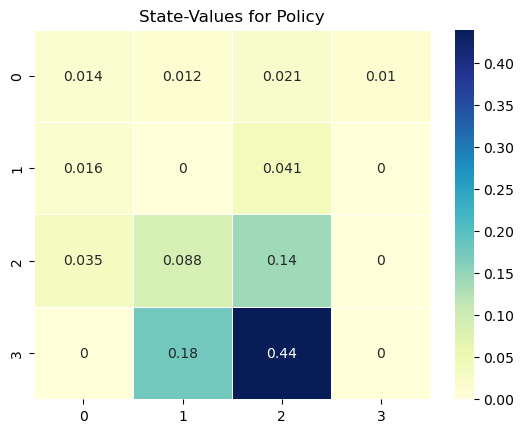

In [6]:
ax = sns.heatmap(V.reshape((4, 4)), cmap="YlGnBu", linewidths=.5, annot=True)
plt.title("State-Values for Policy")
plt.show()

In [7]:
def q_from_v(env, V, s, gamma=1):
    q = np.zeros(env.unwrapped.action_space.n)
    for a in range(env.unwrapped.action_space.n):
        for prob, next_state, reward, done in env.P[s][a]:
            q[a] += prob * (reward + gamma * V[next_state])
    return q

In [8]:
Q = np.zeros([env.unwrapped.observation_space.n, env.unwrapped.action_space.n])
for s in range(env.unwrapped.observation_space.n):
    Q[s] = q_from_v(env, V, s)
print("Action-Value Function:")
print(Q)

Action-Value Function:
[[0.0147094  0.01393978 0.01393978 0.01317015]
 [0.00852356 0.01163091 0.0108613  0.01550788]
 [0.02444514 0.02095298 0.02406033 0.01435346]
 [0.01047649 0.01047649 0.00698432 0.01396865]
 [0.02166487 0.01701828 0.01624865 0.01006281]
 [0.         0.         0.         0.        ]
 [0.05433538 0.04735105 0.05433538 0.00698432]
 [0.         0.         0.         0.        ]
 [0.01701828 0.04099204 0.03480619 0.04640826]
 [0.07020885 0.11755991 0.10595784 0.05895312]
 [0.18940421 0.17582037 0.16001424 0.04297382]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.08799677 0.20503718 0.23442716 0.17582037]
 [0.25238823 0.53837051 0.52711478 0.43929118]
 [0.         0.         0.         0.        ]]


In [9]:
def policy_improvement(env, V, gamma=1):
    policy = np.zeros([env.unwrapped.observation_space.n, env.unwrapped.action_space.n]) / env.unwrapped.action_space.n
    for s in range(env.unwrapped.observation_space.n):
        q = q_from_v(env, V, s, gamma)
        
        # OPTION 1: construct a deterministic policy 
        # policy[s][np.argmax(q)] = 1
        
        # OPTION 2: construct a stochastic policy that puts equal probability on maximizing actions
        best_a = np.argwhere(q==np.max(q)).flatten()
        policy[s] = np.sum([np.eye(env.unwrapped.action_space.n)[i] for i in best_a], axis=0)/len(best_a)
        
    return policy

In [48]:
def policy_iteration(env, gamma=1, theta=1e-8):
    policy = np.ones([env.unwrapped.observation_space.n, env.unwrapped.action_space.n]) / env.unwrapped.action_space.n
    counter = 0
    average_rewards = []
    while True:
        V = policy_evaluation(env, policy, gamma, theta)
        new_policy = policy_improvement(env, V)
        
        
        policy_total_reward = 0
        policy_average_reward = 0
        for i in range(len(V)):
            policy_total_reward += V[i]
        
        policy_average_reward = policy_total_reward / len(V)
        
        average_rewards.append(policy_average_reward)
        
        counter += 1
        
        
        # OPTION 1: stop if the policy is unchanged after an improvement step
        if (new_policy == policy).all():
            break;
        
        # OPTION 2: stop if the value function estimates for successive policies has converged
        # if np.max(abs(policy_evaluation(env, policy) - policy_evaluation(env, new_policy))) < theta*1e2:
        #    break;
        
        policy = copy.copy(new_policy)
        
    
    episodes = np.arange(counter)
    plt.plot(episodes, average_rewards)
    plt.show()
    print(counter)
    
    
    return policy, V

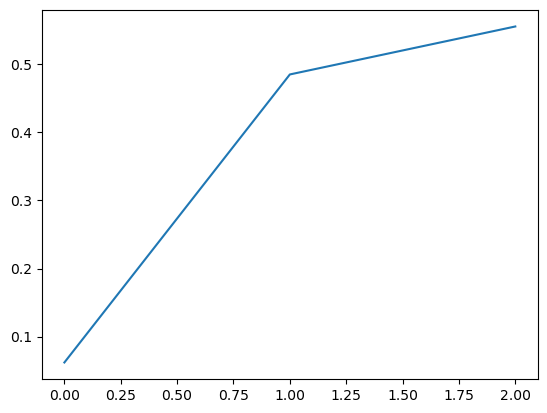

3


In [49]:
policy_pi, V_pi = policy_iteration(env)

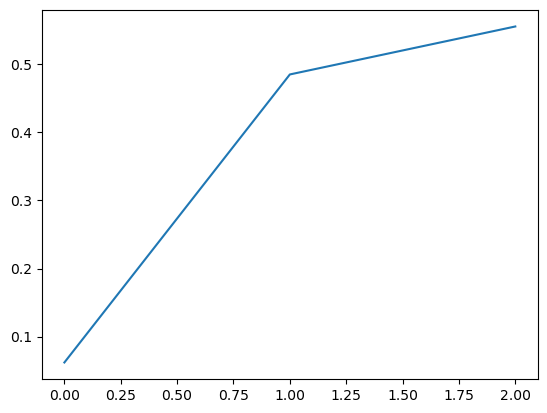

3

Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):
[[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]] 



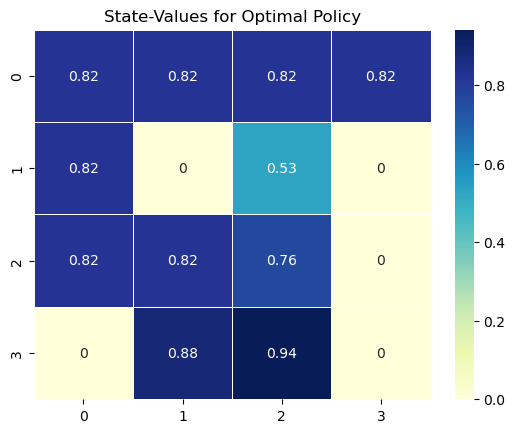

In [50]:
# obtain the optimal policy and optimal state-value function
policy_pi, V_pi = policy_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_pi,"\n")

ax2 = sns.heatmap(V_pi.reshape((4, 4)), cmap="YlGnBu", linewidths=.5, annot=True)
plt.title("State-Values for Optimal Policy")
plt.show()

In [12]:
newV = policy_evaluation(env, policy_pi, gamma=1, theta=1e-8)
newV
total_reward = 0
for i in range(len(newV)):
    total_reward += newV[i]
    
print(total_reward/len(newV))

0.5551469584894231


In [13]:
def value_iteration(env, gamma=1, theta=1e-8):
    V = np.zeros(env.unwrapped.observation_space.n)
    while True:
        delta = 0
        for s in range(env.unwrapped.observation_space.n):
            v = V[s]
            V[s] = max(q_from_v(env, V, s, gamma))
            delta = max(delta,abs(V[s]-v))
        if delta < theta:
            break
    policy = policy_improvement(env, V, gamma)
    return policy, V


Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):
[[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]] 



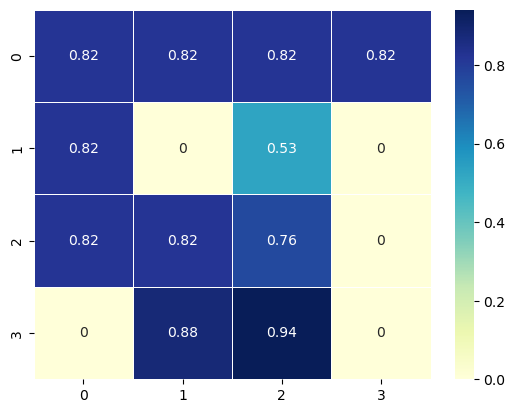

In [14]:
policy_vi, V_vi = value_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_vi,"\n")

# plot the optimal state-value function
ax23 = sns.heatmap(V_vi.reshape((4, 4)), cmap="YlGnBu", linewidths=.5, annot=True)
plt.show()

In [15]:
total_reward = 0
for i in range(len(V_vi)):
    total_reward += V_vi[i]
total_reward

8.882351322605881

In [16]:
def policy_iteration2(env, gamma=1, theta=1e-8):
    def policy_evaluation(policy, V, priority_queue):
        while len(priority_queue) > 0:
            s = priority_queue.pop()
            v = V[s]
            V[s] = sum(policy[s][a] * sum(prob * (reward + gamma * V[next_state]) for prob, next_state, reward, _ in env.P[s][a]) for a in range(env.nA))
            priority_queue.extend(env.P[s][a][0][1] for a in range(env.nA) if env.P[s][a])  # Update priority for successor states
    
    def policy_improvement(V):
        new_policy = np.zeros([env.nS, env.nA])
        for s in range(env.nS):
            q_values = [sum(prob * (reward + gamma * V[next_state]) for prob, next_state, reward, _ in env.P[s][a]) for a in range(env.nA)]
            best_action = np.argmax(q_values)
            new_policy[s][best_action] = 1
        return new_policy
    
    policy = np.ones([env.nS, env.nA]) / env.nA
    V = np.zeros(env.nS)
    priority_queue = list(range(env.nS))  # Initialize priority queue with all states
    
    while True:
        policy_evaluation(policy, V, priority_queue)
        new_policy = policy_improvement(V)
        
        # Stop condition: If the policy is unchanged after an improvement step
        if np.array_equal(new_policy, policy):
            break
        
        policy = copy.deepcopy(new_policy)
    
    return policy, V


In [17]:
bpol_pi, bV_pi = policy_iteration2(env, gamma=1, theta=1e-8)

bV = policy_evaluation(env, policy_pi, gamma=1, theta=1e-8)
total_reward = 0
for i in range(len(bV)):
    total_reward += bV[i]
    
print(total_reward/len(bV))

# newV = policy_evaluation(env, policy_pi, gamma=1, theta=1e-8)

AttributeError: 'FrozenLakeEnv' object has no attribute 'nS'